# Explore here

In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import f_classif, SelectKBest
import numpy as np

# Creamos una carpeta para los datos si no existe
carpeta_datos = "./datos"
os.makedirs(carpeta_datos, exist_ok=True)

# Bajamos los datos de internet y los guardamos
enlace = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
ruta_datos = os.path.join(carpeta_datos, "AB_NYC_2019.csv")
df = pd.read_csv(enlace)
df.to_csv(ruta_datos, index=False)

#Mostramos los primeros datos
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [52]:
# Dimensiones
df.shape

# Obtener información sobre tipos de datos y valores no nulos
print("Tipos de datos y valores: ")
df.info()

Tipos de datos y valores: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_

In [53]:
# ¿Hay duplicados?
df.duplicated().sum()

np.int64(0)

In [54]:
# No los había pero sin considerar la columna id
df.drop("id", axis = 1).duplicated().sum()

np.int64(0)

In [55]:
# Eliminamos columnas no relevantes para el análisis
# Los nombres las ids, reviews también por que el precio no sube por la cantidad de reviews al mes, quizas si por las totales y la latitude y longitude ya tenemos el neighbour que nos da más datos que unos números que son dificiles de representar.
df.drop(["id", "name", "host_id", "host_name", "last_review", "reviews_per_month", "latitude", "longitude"], axis=1, inplace=True)

In [4]:
# Vemos la info ahora
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   neighbourhood_group             48895 non-null  object
 1   neighbourhood                   48895 non-null  object
 2   room_type                       48895 non-null  object
 3   price                           48895 non-null  int64 
 4   minimum_nights                  48895 non-null  int64 
 5   number_of_reviews               48895 non-null  int64 
 6   calculated_host_listings_count  48895 non-null  int64 
 7   availability_365                48895 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.0+ MB


In [6]:
#Agrupado la zona donde están
df.neighbourhood_group.value_counts()

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

In [ ]:
# Zona exacta donde están
df.neighbourhood.value_counts()

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Fort Wadsworth           1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

In [27]:
# Tipo de habitación
df.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

In [29]:
# Precio por noche
df.price.value_counts()

price
100     2051
150     2047
50      1534
60      1458
200     1401
        ... 
1080       1
1299       1
1295       1
519        1
1978       1
Name: count, Length: 674, dtype: int64

In [30]:
# Minimo de noches
df.minimum_nights.value_counts()

minimum_nights
1      12720
2      11696
3       7999
30      3760
4       3303
       ...  
275        1
182        1
114        1
85         1
36         1
Name: count, Length: 109, dtype: int64

In [31]:
# Número de reviews
df.number_of_reviews.value_counts()

number_of_reviews
0      10052
1       5244
2       3465
3       2520
4       1994
       ...  
417        1
368        1
436        1
310        1
341        1
Name: count, Length: 394, dtype: int64

In [36]:
# Número total de propiedades públicadas por el host
df.calculated_host_listings_count.value_counts()

calculated_host_listings_count
1      32303
2       6658
3       2853
4       1440
5        845
6        570
8        416
7        399
327      327
9        234
232      232
10       210
96       192
12       180
13       130
121      121
11       110
52       104
103      103
33        99
49        98
91        91
87        87
15        75
14        70
23        69
17        68
34        68
65        65
31        62
28        56
18        54
50        50
25        50
47        47
43        43
20        40
39        39
37        37
32        32
30        30
29        29
27        27
26        26
21        21
19        19
16        16
Name: count, dtype: int64

In [38]:
# Disponibilidad de 365 días
df.availability_365.value_counts()

availability_365
0      17533
365     1295
364      491
1        408
89       361
       ...  
195       26
196       24
183       24
181       23
202       20
Name: count, Length: 366, dtype: int64

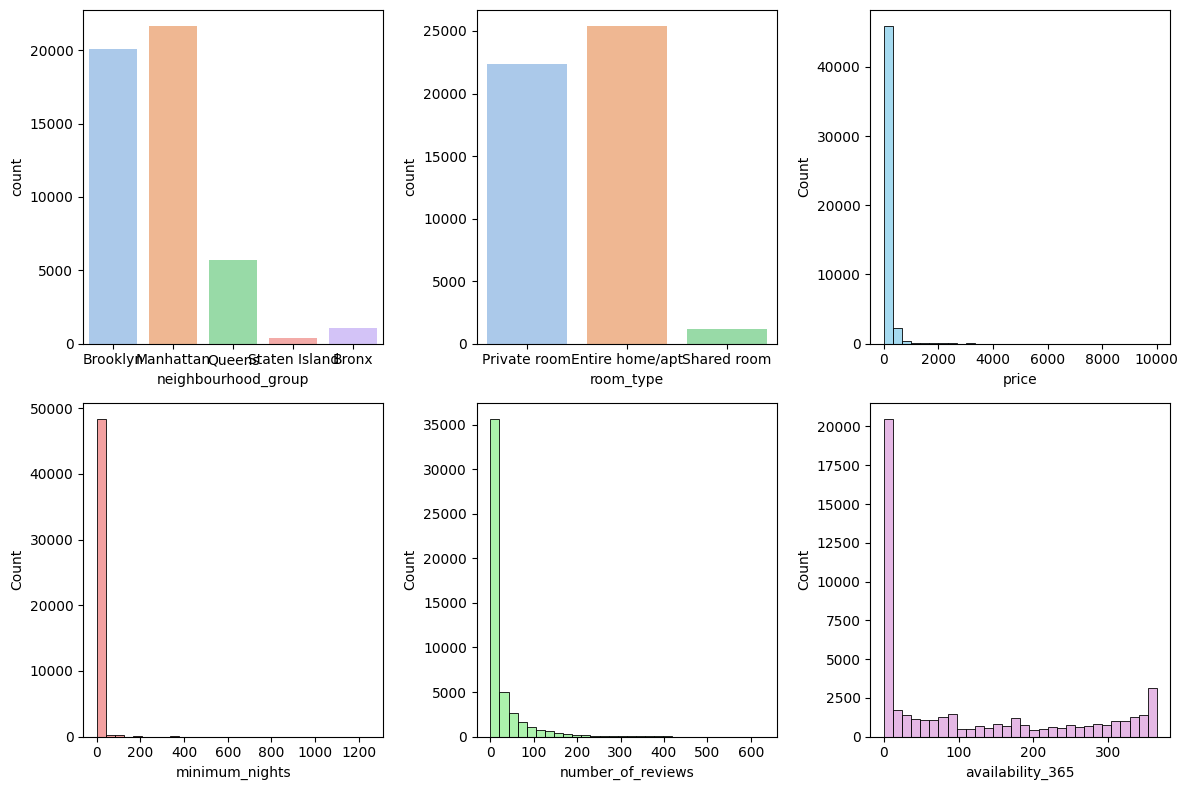

In [31]:
fig, axis = plt.subplots(2, 3, figsize=(12, 8))

sns.countplot(ax=axis[0, 0], data=df, x="neighbourhood_group", palette='pastel', hue="neighbourhood_group", legend=False)
sns.countplot(ax=axis[0, 1], data=df, x="room_type", palette='pastel', hue="room_type", legend=False)
sns.histplot(ax=axis[0, 2], data=df, x="price", bins=30, color='skyblue')
sns.histplot(ax=axis[1, 0], data=df, x="minimum_nights", bins=30, color='lightcoral')
sns.histplot(ax=axis[1, 1], data=df, x="number_of_reviews", bins=30, color='lightgreen')
sns.histplot(ax=axis[1, 2], data=df, x="availability_365", bins=30, color='plum')

plt.tight_layout()
plt.show()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   neighbourhood_group             48895 non-null  object
 1   neighbourhood                   48895 non-null  object
 2   room_type                       48895 non-null  object
 3   price                           48895 non-null  int64 
 4   minimum_nights                  48895 non-null  int64 
 5   number_of_reviews               48895 non-null  int64 
 6   calculated_host_listings_count  48895 non-null  int64 
 7   availability_365                48895 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.0+ MB


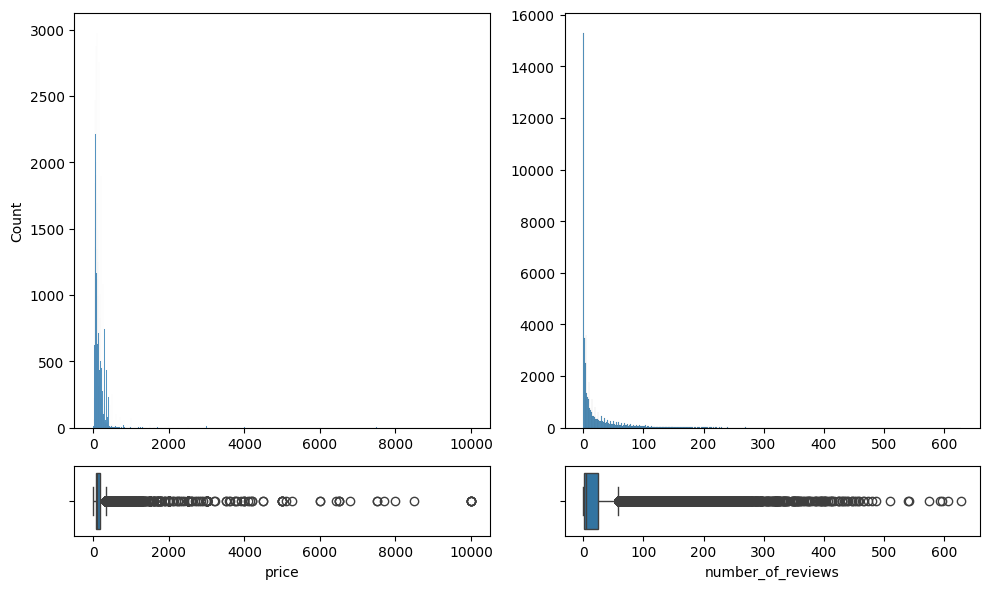

In [33]:
# Histogramas y diagramas de caja precio y numero de reseñas
fig, axis = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})

sns.histplot(ax=axis[0, 0], data=df, x="price").set(xlabel=None)
sns.boxplot(ax=axis[1, 0], data=df, x="price")

sns.histplot(ax=axis[0, 1], data=df, x="number_of_reviews").set(xlabel=None, ylabel=None)
sns.boxplot(ax=axis[1, 1], data=df, x="number_of_reviews")

plt.tight_layout()
plt.show()

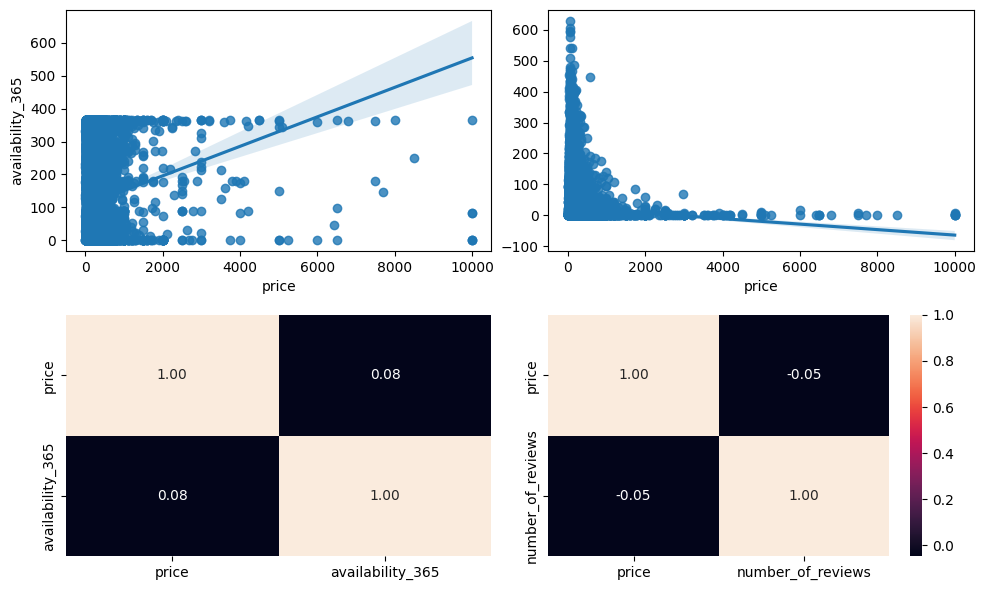

In [34]:
# Diagrama de dispersión multiple
fig, axis = plt.subplots(2, 2, figsize=(10, 6))

sns.regplot(ax=axis[0, 0], data=df, x="price", y="availability_365")
sns.heatmap(df[["price", "availability_365"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)

sns.regplot(ax=axis[0, 1], data=df, x="price", y="number_of_reviews").set(ylabel=None)
sns.heatmap(df[["price", "number_of_reviews"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

plt.tight_layout()
plt.show()

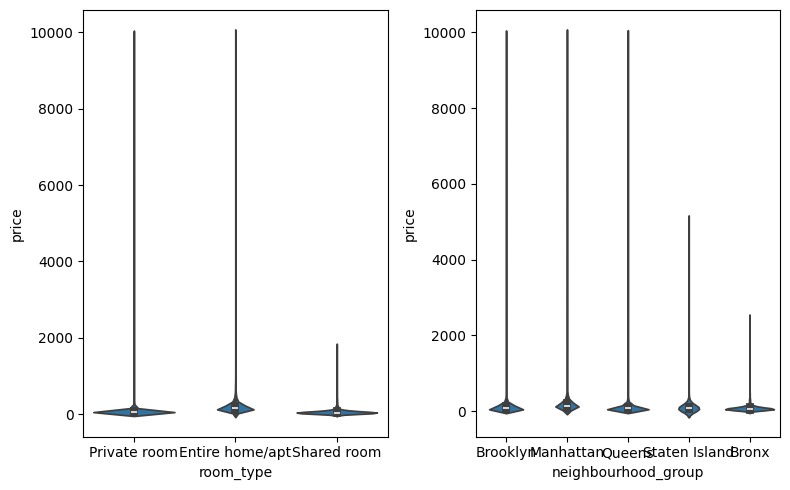

In [35]:
#Violin plots
fig, axis = plt.subplots(1, 2, figsize=(8, 5))

sns.violinplot(ax=axis[0], x='room_type', y='price', data=df)
sns.violinplot(ax=axis[1], x='neighbourhood_group', y='price', data=df)

plt.tight_layout()
plt.show()

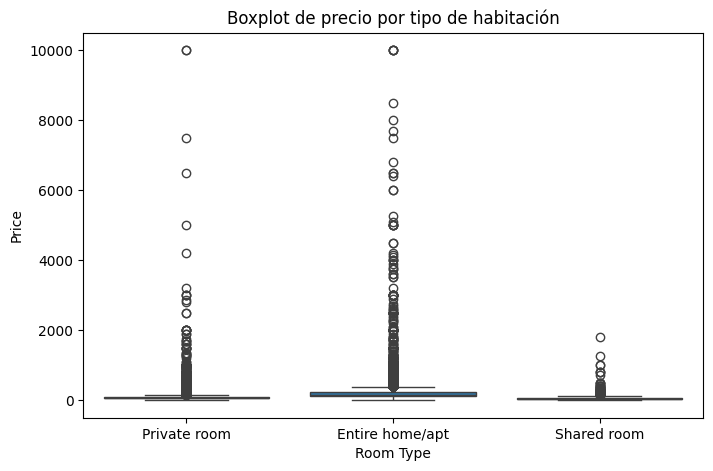

In [36]:
plt.figure(figsize=(8, 5))

sns.boxplot(x='room_type', y='price', data=df)

plt.title('Boxplot de precio por tipo de habitación')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

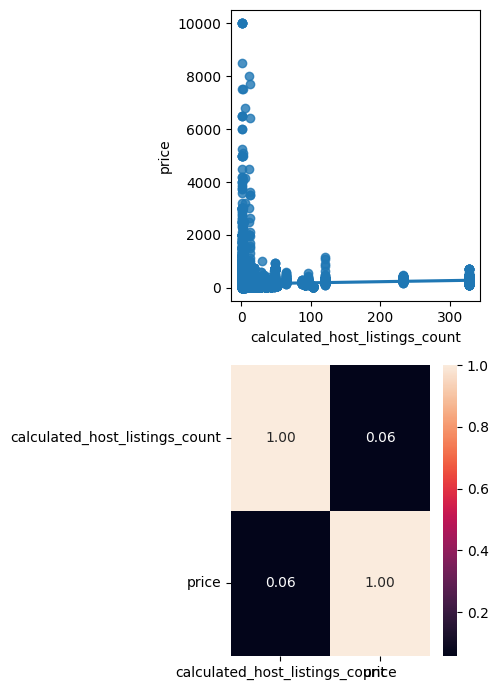

In [37]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "calculated_host_listings_count", y = "price")
sns.heatmap(df[["calculated_host_listings_count", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])

plt.tight_layout()
plt.show()

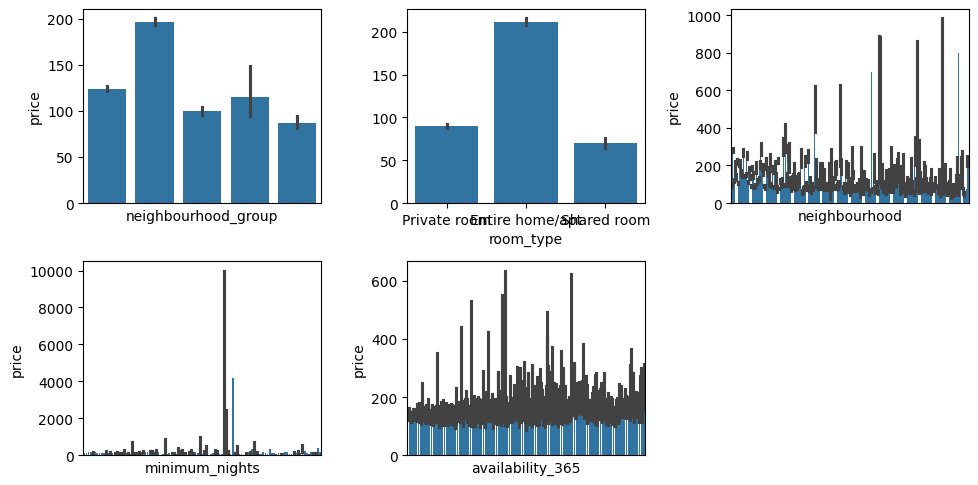

In [41]:
fig, axis = plt.subplots(2, 3, figsize = (10, 5))

sns.barplot(ax=axis[0, 0], data=df, x="neighbourhood_group", y="price").set_xticks([])
sns.barplot(ax = axis[0, 1], data = df, x = "room_type", y = "price").set(ylabel = None)
sns.barplot(ax = axis[0, 2], data = df, x = "neighbourhood", y = "price").set_xticks([])
sns.barplot(ax = axis[1, 0], data = df, x = "minimum_nights", y = "price").set_xticks([])
sns.barplot(ax = axis[1, 1], data = df, x = "availability_365", y = "price").set_xticks([])

plt.tight_layout()
fig.delaxes(axis[1, 2])

plt.show()


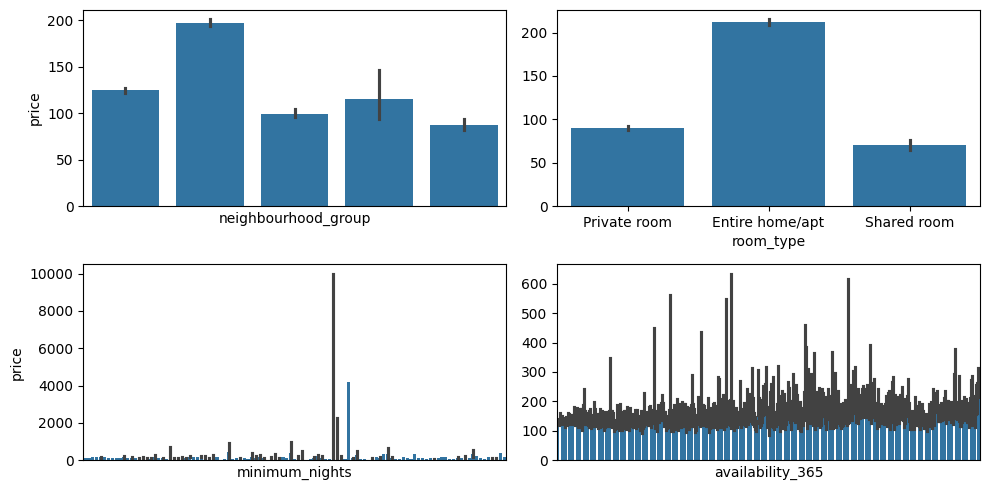

In [48]:
fig, axis = plt.subplots(2, 2, figsize=(10, 5))

sns.barplot(ax=axis[0, 0], data=df, x="neighbourhood_group", y="price").set_xticks([])
sns.barplot(ax=axis[0, 1], data=df, x="room_type", y="price").set(ylabel=None)
sns.barplot(ax=axis[1, 0], data=df, x="minimum_nights", y="price").set_xticks([])
sns.barplot(ax=axis[1, 1], data=df, x="availability_365", y="price").set(ylabel=None, xticks=[])

# Ajuste
plt.tight_layout()

plt.show()

In [7]:
#fig, axis = plt.subplots(2, 3, figsize=(10, 6))
#He tenido que quitar los neighbourhood por que me explotaban el kernel en general esto no se pùede hacer
#crosstab_ng = pd.crosstab(df['neighbourhood_group'], df['price'])
#crosstab_ng.div(crosstab_ng.sum(1).astype(float), axis=0)
#crosstab_ng.plot(kind='bar', stacked=True, ax=axis[0, 0])

#crosstab_rt = pd.crosstab(df['room_type'], df['price'])
#crosstab_rt.div(crosstab_rt.sum(1).astype(float), axis=0)
#crosstab_rt.plot(kind='bar', stacked=True, ax=axis[0, 2])

#crosstab_mn = pd.crosstab(df['minimum_nights'], df['price'])
#crosstab_mn.div(crosstab_mn.sum(1).astype(float), axis=0)
#crosstab_mn.plot(kind='bar', stacked=True, ax=axis[1, 0])

#plt.tight_layout()
#fig.delaxes(axis[1, 2])

#plt.show()

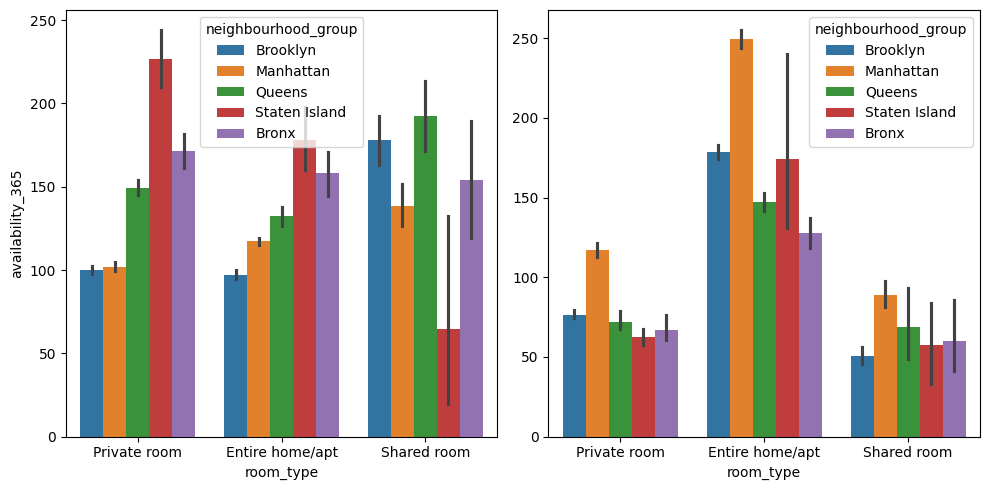

In [8]:
fig, axis = plt.subplots(figsize=(10, 5), ncols=2)

sns.barplot(ax=axis[0], data=df, x="room_type", y="availability_365", hue="neighbourhood_group")

sns.barplot(ax=axis[1], data=df, x="room_type", y="price", hue="neighbourhood_group").set(ylabel=None)

plt.tight_layout()
plt.show()

In [56]:
df["room_type_n"] = pd.factorize(df["room_type"])[0]
df["neighbourhood_group_n"] = pd.factorize(df["neighbourhood_group"])[0]

In [57]:
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n
0,Brooklyn,Kensington,Private room,149,1,9,6,365,0,0
1,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,1,1
2,Manhattan,Harlem,Private room,150,3,0,1,365,0,1
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,1,0
4,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,1,1


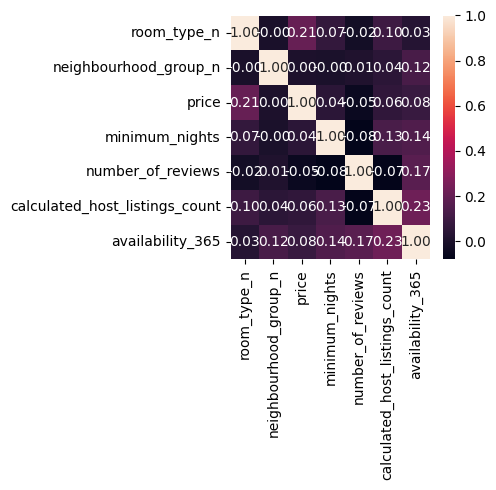

In [58]:
fig, axis = plt.subplots(figsize=(5, 5))
sns.heatmap(df[["room_type_n", "neighbourhood_group_n", "price", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

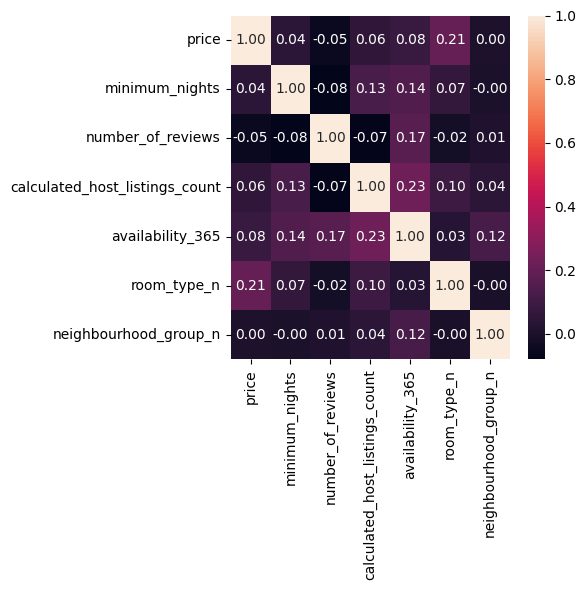

In [59]:
fig, axis = plt.subplots(figsize=(6, 6))
sns.heatmap(df[["price", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "room_type_n", "neighbourhood_group_n"]].corr(), annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

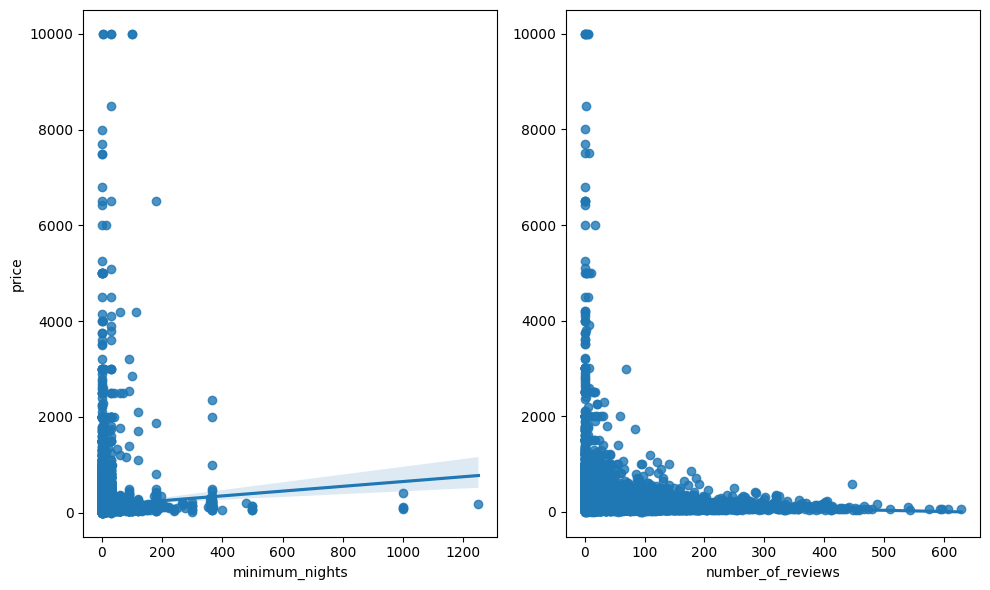

In [13]:
fig, axis = plt.subplots(figsize=(10, 6), ncols=2)

sns.regplot(ax=axis[0], data=df, x="minimum_nights", y="price")
sns.regplot(ax=axis[1], data=df, x="number_of_reviews", y="price").set(ylabel=None)

plt.tight_layout()
plt.show()


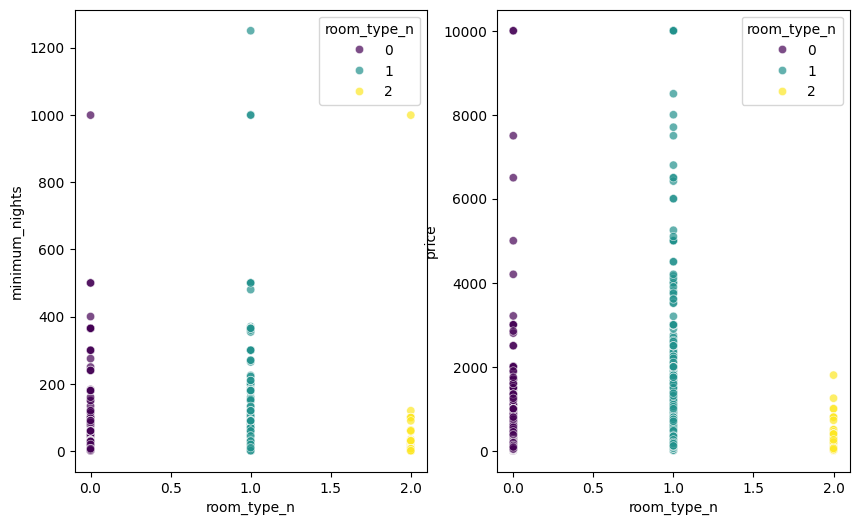

In [61]:
fig, axis = plt.subplots(figsize=(10, 6), ncols=2)

sns.scatterplot(ax=axis[0], data=df, x='room_type_n', y='minimum_nights', hue='room_type_n', palette='viridis', alpha=0.7)
sns.scatterplot(ax=axis[1], data=df, x='room_type_n', y='price', hue='room_type_n', palette='viridis', alpha=0.7)

plt.show()

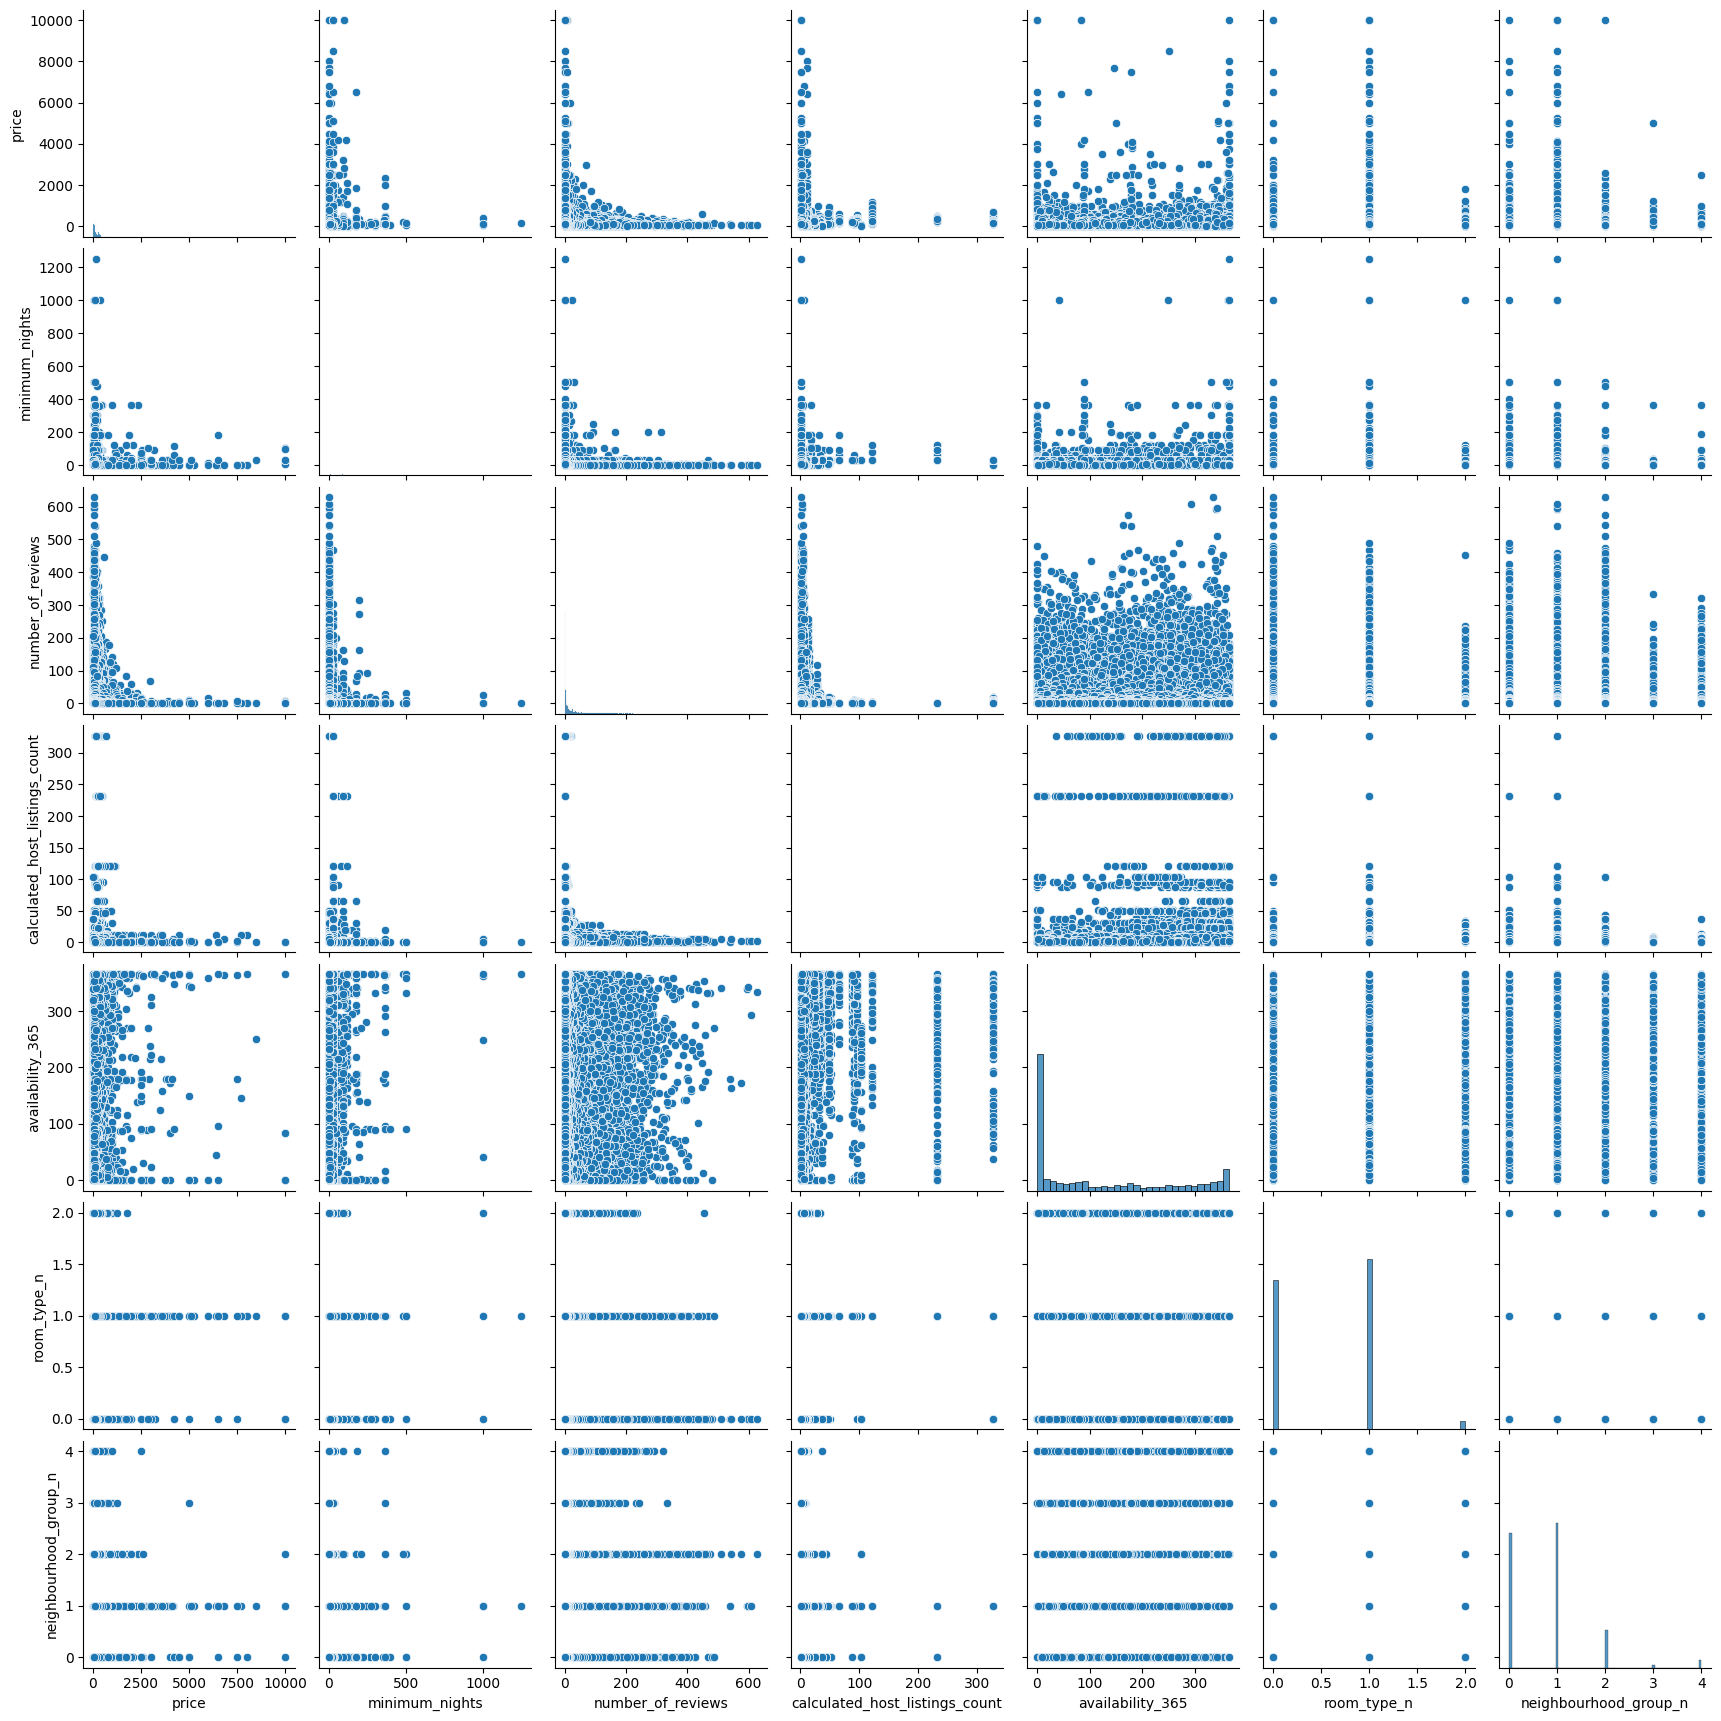

In [60]:
# Relaciones todos con todos
sns.pairplot(data = df)

In [62]:
df.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,7.143982,112.781327,0.567113,0.786911
std,240.154170,20.510550,44.550582,32.952519,131.622289,0.541249,0.844386
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,69.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,106.000000,3.000000,5.000000,1.000000,45.000000,1.000000,1.000000
75%,175.000000,5.000000,24.000000,2.000000,227.000000,1.000000,1.000000
max,10000.000000,1250.000000,629.000000,327.000000,365.000000,2.000000,4.000000


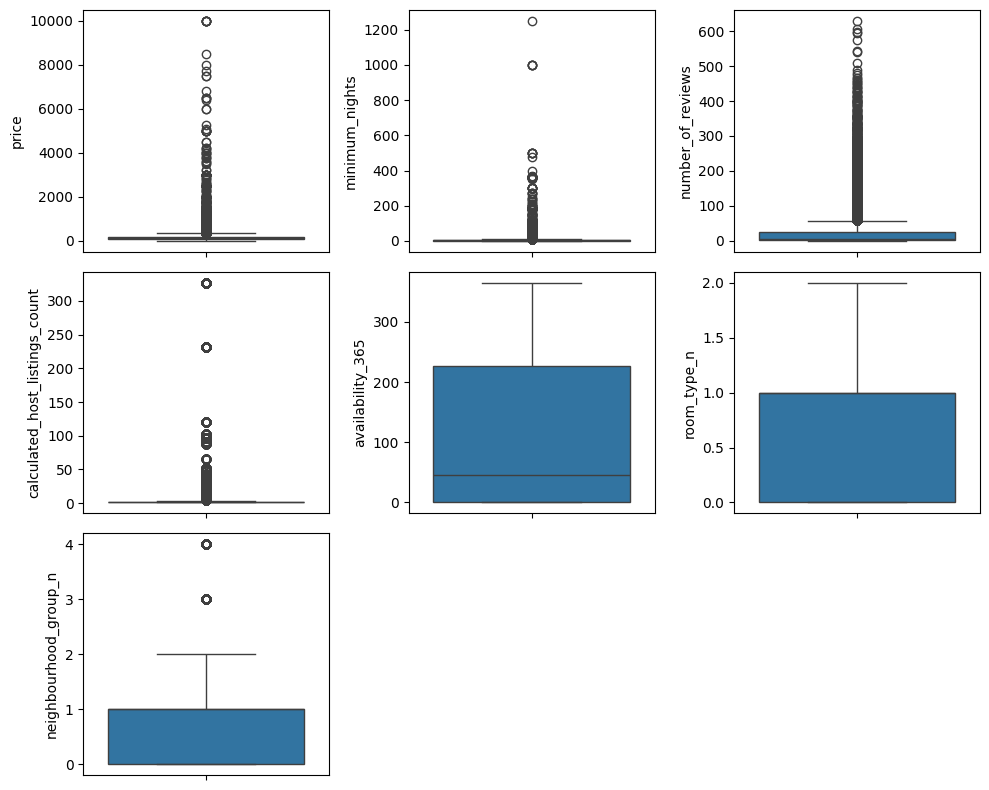

In [63]:
fig, axis = plt.subplots(3, 3, figsize=(10, 8))

sns.boxplot(ax=axis[0, 0], data=df, y="price")
sns.boxplot(ax=axis[0, 1], data=df, y="minimum_nights")
sns.boxplot(ax=axis[0, 2], data=df, y="number_of_reviews")
sns.boxplot(ax=axis[1, 0], data=df, y="calculated_host_listings_count")
sns.boxplot(ax=axis[1, 1], data=df, y="availability_365")
sns.boxplot(ax=axis[1, 2], data=df, y="room_type_n")
sns.boxplot(ax=axis[2, 0], data=df, y="neighbourhood_group_n")

fig.delaxes(axis[2, 1])
fig.delaxes(axis[2, 2])
plt.tight_layout()
plt.show()


In [64]:
precio_est = df["price"].describe()
precio_est

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [9]:
price_iqr = precio_est["75%"] - precio_est["25%"]
upper_limit = precio_est["75%"] + 1.5 * price_iqr
lower_limit = precio_est["25%"] - 1.5 * price_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(price_iqr, 2)}")


Los límites superior e inferior para la búsqueda de outliers son 334.0 y -90.0, con un rango intercuartílico de 106.0


In [10]:
df = df[df["price"] > 0]

In [12]:
precio0 = df[df["price"] == 0].shape[0]

print("Precios de 0: ", precio0)

Precios de 0:  0


In [13]:
#Outliner minimos de noches

est_noches = df["minimum_nights"].describe()
est_noches

count    48884.000000
mean         7.029887
std         20.512224
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [15]:
nights_iqr = est_noches["75%"] - est_noches["25%"]

upper_limit = est_noches["75%"] + 1.5 * nights_iqr
lower_limit = est_noches["25%"] - 1.5 * nights_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(price_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 11.0 y -5.0, con un rango intercuartílico de 106.0


In [16]:
df = df[df["minimum_nights"] <= 15]

In [21]:
#Comprobamos que se haya borrado bien
minnoc = df[df["minimum_nights"] == 16].shape[0]
minnoc2 = df[df["minimum_nights"] == 15].shape[0]
print("Noches minimas de 16: ", minnoc)
print("Noches minimas de 15, aqui si hay datos: ", minnoc2)

Noches minimas de 16:  0
Noches minimas de 15, aqui si hay datos:  279


In [25]:
#Opiniones
opinion_est = df["number_of_reviews"].describe()
opinion_est

count    43265.000000
mean        25.211950
std         46.292011
min          0.000000
25%          1.000000
50%          6.000000
75%         27.000000
max        629.000000
Name: number_of_reviews, dtype: float64

In [26]:
review_iqr = opinion_est["75%"] - opinion_est["25%"]

upper_limit = opinion_est["75%"] + 1.5 * review_iqr
lower_limit = opinion_est["25%"] - 1.5 * review_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(price_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 66.0 y -38.0, con un rango intercuartílico de 106.0


In [27]:
#Cantidad de casas listadas por huespedes

host = df["calculated_host_listings_count"].describe()
host

count    43265.000000
mean         3.369305
std         21.721688
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [28]:
hostlist_iqr = host["75%"] - host["25%"]

upper_limit = host["75%"] + 1.5 * hostlist_iqr
lower_limit = host["25%"] - 1.5 * hostlist_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(price_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 3.5 y -0.5, con un rango intercuartílico de 106.0


In [30]:
counteoHasta4= sum(1 for x in df["calculated_host_listings_count"] if x in range(0, 5))
count1 = df[df["calculated_host_listings_count"] == 1].shape[0]

print("Contamos 1: ", count1)

Contamos 1:  30253


In [31]:
#Eliminamos valores superiroes a 4
df = df[df["calculated_host_listings_count"] > 4]

In [39]:

# Filtrar los valores que superan el
casas_altas = df[df["price"] >= 101.41]

casas_altas

casas_altas["room_type"].value_counts()

room_type
Entire home/apt    634
Private room       476
Shared room          7
Name: count, dtype: int64

In [38]:
df = df

In [33]:
df.isnull().sum().sort_values(ascending=False)

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [37]:
# en porcentaje
df.isnull().sum().sort_values(ascending=False) / len(df)

neighbourhood_group               0.0
neighbourhood                     0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [65]:
# Calcular la mediana de 'price' agrupando por 'room_type_n' y 'neighbourhood_group_n'
median_prices = df.groupby(['room_type_n', 'neighbourhood_group_n'])['price'].median().reset_index()
median_prices = median_prices.rename(columns={'price': 'median_price'})

median_prices

,room_type_n,neighbourhood_group_n,median_price
0,0,0,65.0
1,0,1,90.0
2,0,2,60.0
3,0,3,50.0
4,0,4,53.5
5,1,0,145.0
6,1,1,191.0
7,1,2,120.0
8,1,3,100.0
9,1,4,100.0


In [66]:
# Fusionar las medianas calculadas con el dataset original
df = pd.merge(df, median_prices, on=['room_type_n', 'neighbourhood_group_n'], how='left')



In [67]:
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,median_price
0,Brooklyn,Kensington,Private room,149,1,9,6,365,0,0,65.0
1,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,1,1,191.0
2,Manhattan,Harlem,Private room,150,3,0,1,365,0,1,90.0
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,1,0,145.0
4,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,1,1,191.0


In [68]:
# Rellenar los valores nulos en 'price' con las medianas calculadas
df['price'].fillna(df['median_price'])

# Eliminar la columna auxiliar 'median_price'
df = df.drop(columns=['median_price'])

In [69]:
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n
0,Brooklyn,Kensington,Private room,149,1,9,6,365,0,0
1,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,1,1
2,Manhattan,Harlem,Private room,150,3,0,1,365,0,1
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,1,0
4,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,1,1


In [70]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
room_type_n                       0
neighbourhood_group_n             0
dtype: int64

In [71]:
#No habia nulls pero por sacaso seria algo asi con las columnas que tuvieran nulls
df.dropna(subset=['neighbourhood_group'], inplace = True)
df.dropna(subset=['room_type'], inplace = True)

In [72]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
room_type_n                       0
neighbourhood_group_n             0
dtype: int64

In [73]:
df.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n
0,Brooklyn,Kensington,Private room,149,1,9,6,365,0,0
1,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,1,1
2,Manhattan,Harlem,Private room,150,3,0,1,365,0,1
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,1,0
4,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,1,1


In [74]:
num_variables = ["number_of_reviews", "minimum_nights", "calculated_host_listings_count", 
                 "availability_365", "neighbourhood_group", "room_type"]

In [75]:

df["room_type"] = pd.factorize(df["room_type"])[0]
df["neighbourhood_group"] = pd.factorize(df["neighbourhood_group"])[0]
df["neighbourhood"] = pd.factorize(df["neighbourhood"])[0]

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df[num_variables])
df_scal = pd.DataFrame(scal_features, index = df.index, columns = num_variables)
df_scal["price"] = df["price"]
df_scal.head()

,number_of_reviews,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group,room_type,price
0,0.014308,0.000000,0.015337,1.000000,0.00,0.0,149
1,0.071542,0.000000,0.003067,0.972603,0.25,0.5,225
2,0.000000,0.001601,0.000000,1.000000,0.25,0.0,150
3,0.429253,0.000000,0.000000,0.531507,0.00,0.5,89
4,0.014308,0.007206,0.000000,0.000000,0.25,0.5,80


In [77]:
from sklearn.feature_selection import chi2, SelectKBest

X = df_scal.drop("price", axis = 1)
y = df_scal["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


selection_model = SelectKBest(chi2, k = 4)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,room_type
0,0.017488,0.000000,0.002740,0.5
1,0.003180,0.000000,0.000000,0.0
2,0.000000,0.003067,0.000000,0.0
3,0.138315,0.000000,0.731507,0.5
4,0.020668,0.000000,0.000000,0.0


In [78]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [79]:
X_test_sel.head(50)

,number_of_reviews,calculated_host_listings_count,availability_365,room_type,price
0,0.098569,0.000000,0.517808,0.5,89
1,0.000000,0.000000,0.200000,0.0,30
2,0.027027,0.000000,0.000000,0.0,120
3,0.007949,1.000000,0.745205,0.5,470
4,0.047695,0.000000,0.082192,0.5,199
5,0.224165,0.000000,0.076712,0.5,170
6,0.001590,0.000000,0.000000,0.0,90
7,0.000000,0.000000,0.331507,0.5,60
8,0.141494,0.000000,0.150685,0.5,150
9,0.058824,0.009202,0.191781,0.5,74
